In [10]:
library(jsonlite)
library(tidyverse)
library(readr)

setwd('C:/Users/Deanna/Documents/Job Stuff/Data Analyst/Raw Data')

# Thought Process

Hey there!

This notebook is a documentation of my thought process as I went through this exercise. Feel free to follow along while I explain how I got from point A to point B (or C).

After reading through the exercise, here's my first brain dump:
- JSON files need to be converted to CSV
- The ER diagram will probably be straightforward with the join between reciepts and users (via userID)
- I need to mess with the data to figure out how to join brands to the reciepts table since the column names and descriptions aren't making the join obvious
- The questions all come in pairs and two can be answered at once in SQL with the use of a temp table, though I would prefer using R for the visualizations but I can do it in SQL. (I really wanted to use ggplot2 ಥ_ಥ )
- for quality issues, we're probably talking looking for outliers, expected values, etc etc. Lots of boxplots for this part.
- from there the write-up should be pretty ezpz!

## Part 0.5: Get Familiar with the Data and Housekeeping

To start, I need to see the data! JSON files are gross imo, but I can turn them into data frames in R and fiddle with them a bit.

In [3]:
brands <- stream_in(file("brands.json"))
receipts <- stream_in(file("receipts.json"))
users <- stream_in(file("users.json"))

opening file input connection.



 Imported 1167 records. Simplifying...


closing file input connection.

opening file input connection.



 Imported 1119 records. Simplifying...


closing file input connection.

opening file input connection.



 Imported 495 records. Simplifying...


closing file input connection.



In [4]:
brands$'_id' <- flatten(brands$'_id')
brands$cpg$`$id` <- flatten(brands$cpg$`$id`)

brands <- brands %>%
            as_tibble() %>%
            unnest(cpg)

brands$'_id' <- as.character(brands$'_id')
brands$`$id` <- as.character(brands$`$id`)

head(brands)

_id,barcode,category,categoryCode,$id,$ref,name,topBrand,brandCode
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>
601ac115be37ce2ead437551,511111019862,Baking,BAKING,601ac114be37ce2ead437550,Cogs,test brand @1612366101024,FALSE,NA
601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Cogs,Starbucks,FALSE,STARBUCKS
601ac142be37ce2ead43755d,511111819905,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146176,FALSE,TEST BRANDCODE @1612366146176
601ac142be37ce2ead43755a,511111519874,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146051,FALSE,TEST BRANDCODE @1612366146051
601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,test brand @1612366146827,FALSE,TEST BRANDCODE @1612366146827
601ac142be37ce2ead43755b,511111719885,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146091,FALSE,TEST BRANDCODE @1612366146091


In [5]:
receipts$'_id' <- flatten(receipts$'_id')
receipts$'_id' <- as.character(receipts$'_id')

receipts <- receipts %>%
            as_tibble() %>%
            unnest(rewardsReceiptItemList,names_repair = "unique")

head(receipts)

New names:
• `pointsEarned` -> `pointsEarned...9`
• `pointsEarned` -> `pointsEarned...38`


_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned...9,purchaseDate,⋯,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId,rewardsReceiptStatus,totalSpent,userId
<chr>,<int>,<chr>,<dttm>,<dttm>,<dttm>,<dttm>,<dttm>,<chr>,<dttm>,⋯,<chr>,<lgl>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
5ff1e1eb0a720f0523000575,500,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 09:25:31,2021-01-03 09:25:31,2021-01-03 09:25:31,2021-01-03 09:25:36,2021-01-03 09:25:31,500.0,2021-01-02 18:00:00,⋯,NA,NA,NA,NA,NA,NA,NA,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
5ff1e1bb0a720f052300056b,150,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 09:24:43,2021-01-03 09:24:43,2021-01-03 09:24:43,2021-01-03 09:24:48,2021-01-03 09:24:43,150.0,2021-01-02 09:24:43,⋯,NA,NA,NA,NA,NA,NA,NA,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
5ff1e1bb0a720f052300056b,150,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 09:24:43,2021-01-03 09:24:43,2021-01-03 09:24:43,2021-01-03 09:24:48,2021-01-03 09:24:43,150.0,2021-01-02 09:24:43,⋯,NA,NA,NA,NA,NA,NA,NA,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
5ff1e1f10a720f052300057a,5,All-receipts receipt bonus,2021-01-03 09:25:37,2021-01-03 09:25:37,NA,2021-01-03 09:25:42,NA,5,2021-01-02 18:00:00,⋯,NA,NA,NA,NA,NA,NA,NA,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
5ff1e1ee0a7214ada100056f,5,All-receipts receipt bonus,2021-01-03 09:25:34,2021-01-03 09:25:34,2021-01-03 09:25:34,2021-01-03 09:25:39,2021-01-03 09:25:34,5.0,2021-01-02 18:00:00,⋯,NA,NA,NA,NA,NA,NA,NA,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
5ff1e1d20a7214ada1000561,5,All-receipts receipt bonus,2021-01-03 09:25:06,2021-01-03 09:25:06,2021-01-03 09:25:11,2021-01-03 09:25:11,2021-01-03 09:25:06,5.0,2021-01-02 09:25:06,⋯,NA,NA,NA,NA,NA,NA,NA,FINISHED,1.00,5ff1e194b6a9d73a3a9f1052


In [6]:
users$'_id' <- flatten(users$'_id')
users$'_id' <- as.character(users$'_id')

users <- tibble(users)
head(users)

_id,active,createdDate,lastLogin,role,signUpSource,state
<chr>,<lgl>,<dttm>,<dttm>,<chr>,<chr>,<chr>
5ff1e194b6a9d73a3a9f1052,TRUE,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI
5ff1e194b6a9d73a3a9f1052,TRUE,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI
5ff1e194b6a9d73a3a9f1052,TRUE,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI
5ff1e1eacfcf6c399c274ae6,TRUE,2021-01-03 09:25:30,2021-01-03 09:25:30,consumer,Email,WI
5ff1e194b6a9d73a3a9f1052,TRUE,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI
5ff1e194b6a9d73a3a9f1052,TRUE,2021-01-03 09:24:04,2021-01-03 09:25:37,consumer,Email,WI


Okay I definitely felt my soul leave my body while I figured out how to parse the JSON files. But the rest *should* be easy...

## Basic Data Cleanup

Some of those columns names are ARTOCIOUS. Time to fix them!

|**Users**|New Column Name|
|---|---|
|_id|userId|
|active|isActive|
|createdDate||
|lastLogin||
|role||
|signUpSource||
|state||

|**Brands**|New Column Name|
|---|---|
|_id|brandId|
|barcode||
|category||
|categoryCode||
|cpg.id|cpgId|
|cpg.ref|cpgRef|
|name||
|topBrand||
|brandCode||

|**Receipts**|New Column Name|
|---|---|
|_id|receiptId|
|bonusPointsEarned||
|bonusPointsEarnedReason||
|createDate||
|dateScanned||
|finishedDate||
|modifyDate||
|pointsAwardedDate||
|pointsEarned...9|overallPointsEarned|
|purchaseDate||
|purchasedItemCount||
|barcode||
|description||
|finalPrice|totalFinalPrice|
|itemPrice||
|needsFetchReview||
|partnerItemId||
|preventTargetGapPoints||
|quantityPurchased||
|userFlaggedBarcode||
|userFlaggedNewItem||
|userFlaggedPrice||
|userFlaggedQuantity||
|needsFetchReviewReason||
|pointsNotAwardedReason||
|pointsPayerId||
|rewardsGroup||
|rewardsProductPartnerId||
|userFlaggedDescription||
|originalMetaBriteBarcode||
|originalMetaBriteDescription||
|brandCode||
|competitorRewardsGroup||
|discountedItemPrice||
|originalReceiptItemText||
|itemNumber||
|originalMetaBriteQuantityPurchased||
|pointsEarned...38|itemPointsEarned|
|targetPrice||
|competitiveProduct||
|originalFinalPrice||
|originalMetaBriteItemPrice||
|deleted||
|priceAfterCoupon||
|metabriteCampaignId||
|rewardsReceiptStatus||
|totalSpent||
|userId||

In [8]:
#why did dplyr not work? no idea. I didn't want to waste time making it work, so I went with base R

names(users)[1] <- "userId"
names(users)[2] <- "isActive"

names(brands)[1] <- "brandId"
names(brands)[5] <- "cpgId"
names(brands)[6] <- "cpgRef"

names(receipts)[1] <- "receiptId"
names(receipts)[9] <- "overallPointsEarned"
names(receipts)[14] <- "totalFinalPrice"
names(receipts)[38] <- "itemPointsEarned"

In [9]:
#good place to export the CSVs!

#write_csv(brands, "brands.csv", na = "NULL")
#write_csv(receipts, "receipts.csv", na="NULL")
#write_csv(users, "users.csv",na="NULL")

## Part 1: ER Diagram

Finally! The data is now in a format that's usable (at least for SQL). I took the CSVs and took a look at the data in Excel to get an idea of where joins could go. Here's what I concluded:

|List of joins|
|---|
|receipts.rewardsProductPartnerId = brand.cpgId|
|receipts.pointsPayerId = brand.cpgId|
|receipts.brandCode = brand.brandCode|
|receipts.userId = users.userId|

With that, here's the full diagram:
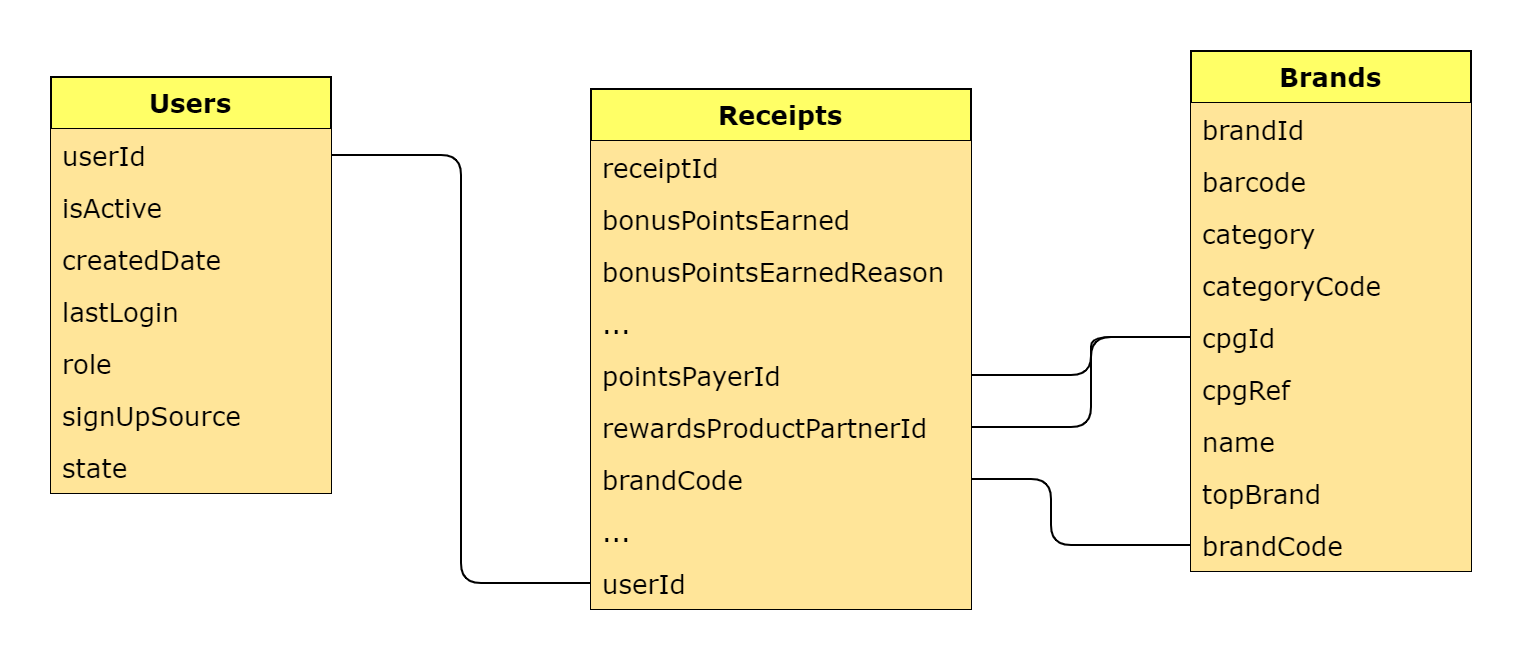

## Part 2: SQL Query

Did I really learn how to make a local server in order to use Microsoft SQL Server? Yes.
Was the process way simpler than I thought? Also yes - apparently it's one line in CMD to get it going so that's cool.

So next I imported the three CSVs into a database to write all my fancy schmancy SQL! Love that dbo schema.

I opted to answer the first two questions from the list:
- What are the top 5 brands by receipts scanned for most recent month?
- How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

I took a quick look and the last receipt was scanned 3/1/21, so I'll assume this month means Feb '21 and last month is Jan '21 so we have a whole month's worth of data for each ranking (one day definitely isn't a big enough sample size to even consider March).

For reference, here's the code (it's not executable in this notebook and I didn't want to spend another 2 hours figuring out how to make it executable):

And here's screenshots of the output!

Feb:
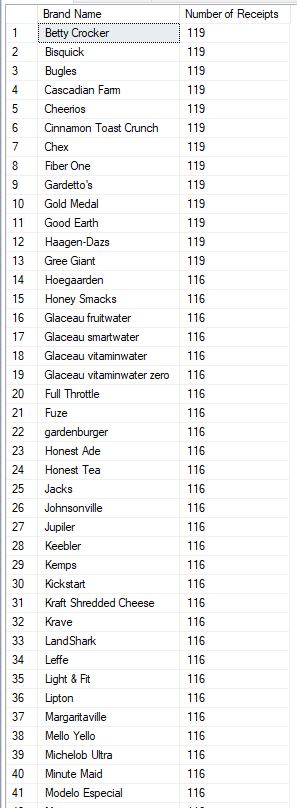

Jan:
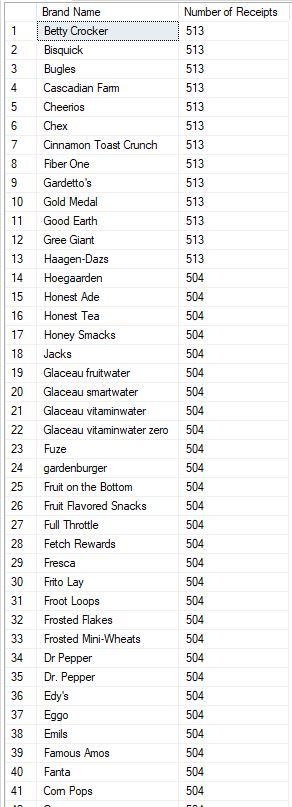

Now I went and checked the number of all rows in receipts for the month of February: there were 194 rows. January had 6,665. We're talking *very* different sample sizes here. I don't like that they're so different, but I can't hand pick the data.

Additionally, after doing three joins that were inclusive, I still had a 13-way tie for the top brand for both months. This tells me there's something that I'm missing. **I will admit here that I can't figure out what's wrong and that I need an extra set of eyes on my work. In order to keep the customer up-to-date, I'll communicate initial findings with the caveat that I'm getting my work checked over and I'll update them with final results once that's complete.**

Sometimes, you've spent too many hours trying things with no improvements and just need to ask for help and move on. (Context: I'm ~10 hours into this exercise and I think the problem is how I expanded the tables at the beginning. The issue is I have no idea what to look for next to fix this, but I want to complete all parts of this exercise.)

## Part 3: Data Quality Checks

And for my next trick: confirming my gut instinct that this data is not great!

So far I've only done superficial data cleanup, so I anticipate finding lots of icky things about the data quality!

First things first.... remember what to look for....